### Nama : Eva Fadhillah Ulia
### NIM  : A11.2022.14283

### PROJECT UAS KOMPUTASI KUANTUM 

# Penggunaan Quantum Machine Learning dengan VQC (Variational Quantum Circuits) dan PCA untuk Klasifikasi Data Kanker Payudara

## 🧩 Import Library

Import berbagai library penting untuk quantum computing (qiskit), visualisasi (matplotlib, seaborn), manipulasi data (numpy, pandas), serta machine learning (scikit-learn).
ParameterVector untuk membuat variabel parameter pada quantum circuit yang nanti bisa dioptimasi.

In [82]:
import qiskit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [83]:
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals
from sklearn.preprocessing import StandardScaler

Keterangan : 
data.data: berisi fitur-fitur numerik (X)
data.target: berisi label klasifikasi (y) → 0 = malignant, 1 = benign
data.feature_names: nama-nama kolom

## Memuat dan Menyiapkan Data

Memuat dataset kanker payudara dan mengubahnya ke bentuk tabel agar mudah diproses.

In [84]:
data = load_breast_cancer()

In [85]:
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# Cek isi data
print(df.head())

   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0             

## Normalisasi Data

Menjadikan nilai semua fitur berada dalam rentang 0 sampai 1 agar model lebih stabil saat dilatih.

In [86]:
x = data.data
y = data.target

In [87]:
x = MinMaxScaler().fit_transform(x)

In [88]:
print(x.shape)

(569, 30)


## Reduksi Dimensi dengan PCA (Principal Component Analysis)

Jika fitur lebih dari 4, gunakan PCA untuk mereduksi fitur menjadi 4 komponen utama agar model quantum lebih efisien.

Jika jumlah data lebih dari 150, ambil sampel acak 150 data untuk mempercepat training.

In [89]:
if x.shape[1] > 4:
    pca = PCA(n_components=4)
    x_reduced = pca.fit_transform(x)
else:
    x_reduced = x

# Jika data record > 150, ambil 150 data secara acak
import numpy as np
if x_reduced.shape[0] > 150:
    idx = np.random.choice(x_reduced.shape[0], 150, replace=False)
    x_reduced = x_reduced[idx]
    y = y[idx]

print("Shape fitur setelah PCA / sampling:", x_reduced.shape)  # seharusnya (150, 4)



Shape fitur setelah PCA / sampling: (150, 4)


## Split Data Train dan Test

Memisahkan data menjadi 80% training dan 20% testing, dengan seed random agar hasil bisa direproduksi.

In [90]:
algorithm_globals.random_seed = 123
train_x, test_x, train_y, test_y = train_test_split(
    x_reduced, y, train_size=0.8, random_state=algorithm_globals.random_seed
)

## Membuat Quantum Circuit untuk Feature Map

Membuat quantum circuit yang mengubah data fitur menjadi bentuk quantum state yang bisa diproses oleh quantum model.

Parameter theta_list nantinya akan diisi nilai fitur asli dan dioptimasi oleh algoritma.



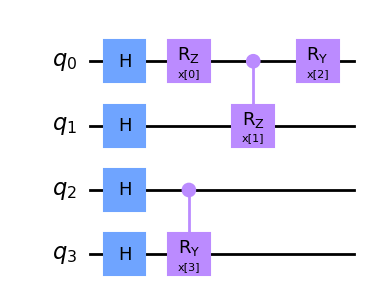

In [91]:
# Definisikan parameter quantum circuit
jum_fitur = x_reduced.shape[1]  # 4 fitur
theta_list = ParameterVector('x', length=jum_fitur)

# Buat quantum circuit dengan 4 qubit
feature_map_1 = QuantumCircuit(jum_fitur)
feature_map_1.h(range(jum_fitur))
feature_map_1.rz(theta_list[0], 0)
feature_map_1.crz(theta_list[1], 0, 1)
feature_map_1.ry(theta_list[2], 0)
feature_map_1.cry(theta_list[3], 2, 3)

# Tampilkan circuit
feature_map_1.draw('mpl')

Untuk memverifikasi apakah folder "styles" yang digunakan oleh Qiskit untuk visualisasi sirkuit ada di instalasi Anda, dan jika ada, untuk menampilkan file-file apa saja yang ada di dalamnya. Ini sangat berguna untuk debugging atau sekadar memahami struktur file internal Qiskit terkait dengan fitur visualisasinya

In [92]:
import qiskit
import os

style_folder = os.path.join(qiskit.__path__[0], "visualization", "circuit", "styles")
print("Folder styles ada?", os.path.exists(style_folder))
print("Isi folder:", os.listdir(style_folder) if os.path.exists(style_folder) else "Folder tidak ada")


Folder styles ada? True
Isi folder: ['bw.json', 'clifford.json', 'textbook.json', 'iqx.json', 'default.json', 'iqx-dark.json']


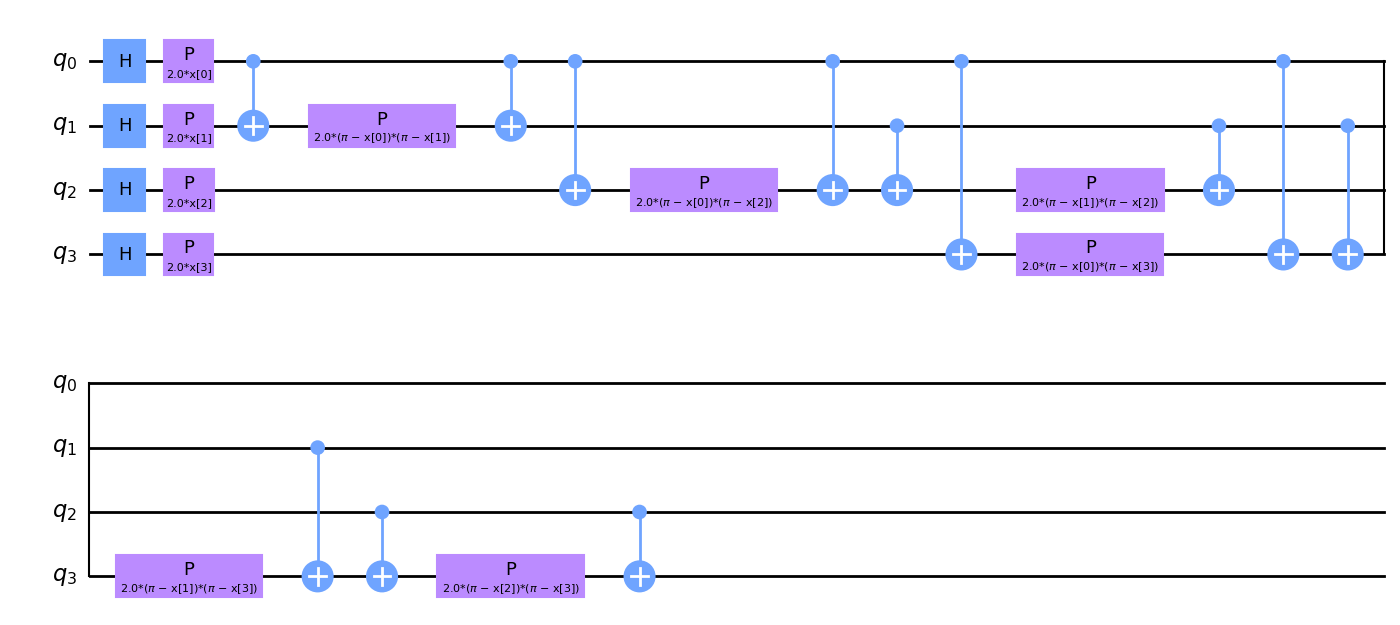

In [94]:
jum_fitur = x_reduced.shape[1]
feature_map = ZZFeatureMap(feature_dimension=jum_fitur, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

## Membuat Quantum Circuit Variasi Lain (Feature Map dan Ansatz)

Menentukan struktur sirkuit yang akan digunakan untuk mempelajari (memprediksi) label dari data.

Ansatz adalah "model" parametrik di komputer kuantum yang kita latih atau optimasi menggunakan komputer klasik untuk menemukan solusi terbaik bagi suatu masalah.

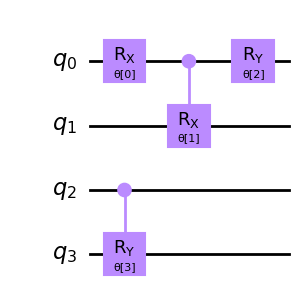

In [95]:
theta_list = ParameterVector('θ', length=jum_fitur)

ansatz_1 = QuantumCircuit(jum_fitur)
ansatz_1.rx(theta_list[0], 0)
ansatz_1.crx(theta_list[1], 0, 1)
ansatz_1.ry(theta_list[2], 0)
ansatz_1.cry(theta_list[3], 2, 3)
ansatz_1.draw('mpl')

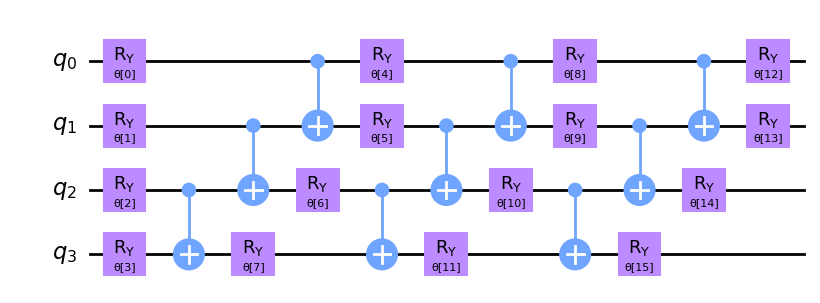

In [96]:
from qiskit.circuit.library import RealAmplitudes

ansatz_2 = RealAmplitudes(num_qubits=jum_fitur, reps=3)
ansatz_2.decompose().draw(output="mpl", style="clifford", fold=20)

## Inisialisasi Optimizer dan Sampler

Optimizer mengatur nilai-nilai variabel kuantum agar akurasi model makin tinggi.
Sampler mengeksekusi sirkuit dan mengambil hasilnya.

In [97]:
from qiskit.algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=10)

In [98]:
from qiskit.primitives import Sampler

sampler = Sampler()


 ## Callback untuk Visualisasi Proses Training

Fungsi untuk menggambar grafik nilai fungsi objektif selama proses training.
Membantu memonitor apakah training semakin baik atau tidak.

In [99]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Nilai fungsi objektif terhadap iterasi")
    plt.xlabel("Iterasi")
    plt.ylabel("Nilai fungsi objektif")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

## Membuat dan Melatih Model VQC (Variational Quantum Classifier)

Membuat model quantum classifier (VQC) dengan komponen sebelumnya.
Melatih model dengan data training.

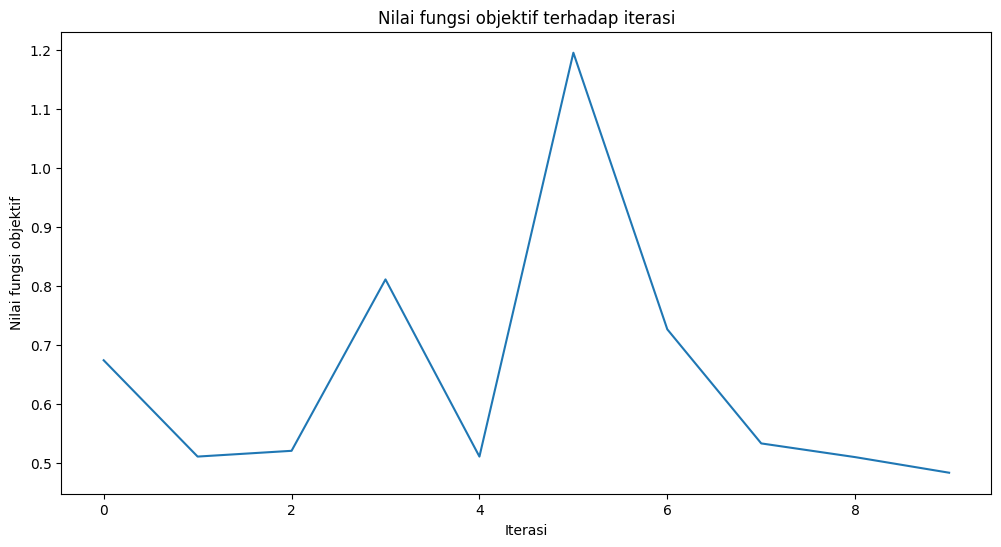

Waktu Training : 1 detik


In [100]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map_1,  # sebagai alternatif: feature_map_2
    ansatz=ansatz_1,            # sebagai alternatif: ansatz_2
    optimizer=optimizer,
    callback=callback_graph,
)

# hapus histori nilai oyektif 
objective_func_vals = []

start = time.time()
vqc.fit(train_x, train_y)
elapsed = time.time() - start

print(f"Waktu Training : {round(elapsed)} detik")

## Mengukur Akurasi

Menghitung seberapa bagus performa model pada data pelatihan dan data uji.

In [101]:
score_pelatihan_1 = vqc.score(train_x, train_y)
score_pengujian_1 = vqc.score(test_x, test_y)

print(f"VQC kuantum pada dataset pelatihan: {score_pelatihan_1:.2f}")
print(f"VQC kuantum pada dataset uji      : {score_pengujian_1:.2f}")

VQC kuantum pada dataset pelatihan: 0.86
VQC kuantum pada dataset uji      : 0.83


## Visualisasi Data dengan 2 Komponen PCA

Mengubah data jadi 2 dimensi dan memplot data berdasarkan kelas untuk visualisasi yang mudah.

<Axes: >

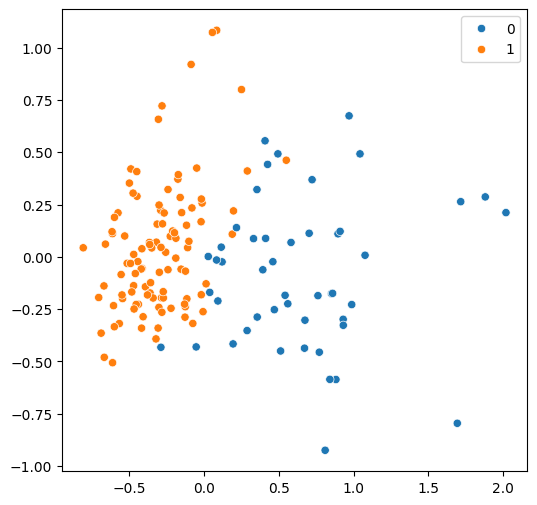

In [102]:
jum_fitur = 2

# Lakukan PCA dengan 2 komponen
pca = PCA(n_components=jum_fitur)
x_PCA = pca.fit_transform(x_reduced)

# Visualisasi
plt.figure(figsize=(6,6))
sns.scatterplot(x=x_PCA[:, 0], y=x_PCA[:, 1], hue=y, palette="tab10")



In [103]:
train_x, test_x, train_y, test_y = train_test_split(
    x_PCA, y, train_size=0.8, random_state=algorithm_globals.random_seed
)

## Eksperimen dengan Ansatz dan Feature Map Lain

Mencoba pola sirkuit quantum lain untuk melihat mana yang hasilnya paling bagus.

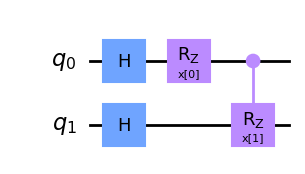

In [104]:
from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit

theta_list = ParameterVector('x', length=jum_fitur)

feature_map_1 = QuantumCircuit(jum_fitur)
feature_map_1.h([0,1])
feature_map_1.rz(theta_list[0], 0)
feature_map_1.crz(theta_list[1], 0, 1)
feature_map_1.draw('mpl')

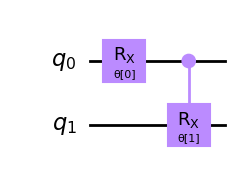

In [105]:
theta_list = ParameterVector('θ', length=jum_fitur)

ansatz_1 = QuantumCircuit(jum_fitur)
ansatz_1.rx(theta_list[0], 0)
ansatz_1.crx(theta_list[1], 0, 1)
ansatz_1.draw('mpl')


### Tabel Perbandingan: `RealAmplitudes` vs `EfficientSU2` (dalam VQC)

| Fitur              | `RealAmplitudes`                                        | `EfficientSU2`                                                  |
| :----------------- | :------------------------------------------------------ | :-------------------------------------------------------------- |
| **Tujuan Utama** | Membuat sirkuit dengan amplitudo nyata yang dapat dioptimalkan. | Membuat sirkuit yang efisien dan fleksibel untuk menjelajahi ruang keadaan kuantum yang luas. |
| **Gerbang Rotasi Qubit Tunggal yang Digunakan** | Umumnya hanya **`RY` (Rotasi di sekitar sumbu Y)**. Ini membatasi rotasi ke bidang tertentu. | Kombinasi **`RY` dan `RZ` (Rotasi di sekitar sumbu Y dan Z)**, atau bahkan `RX`, `RY`, `RZ`. Ini memberikan rotasi yang lebih lengkap dan fleksibel untuk setiap qubit. |
| **Jenis Amplitudo Keadaan Hasil** | Menghasilkan keadaan kuantum dengan **amplitudo nyata** (tidak ada bagian imajiner). | Dapat menghasilkan keadaan kuantum dengan **amplitudo kompleks** (ada bagian nyata dan imajiner). |
| **Gerbang Entanglement** | Menggunakan **`CX` (Controlled-X / CNOT)** untuk menciptakan keterikatan antar qubit. | Menggunakan **`CX` (Controlled-X / CNOT)** atau gerbang entangling lainnya untuk menciptakan keterikatan antar qubit. |
| **Desain** | Lebih sederhana, fokus pada karakteristik amplitudo nyata. | Dirancang agar "hardware-efficient" (efisien untuk perangkat keras kuantum saat ini yang berisik) dan lebih ekspresif. |
| **Fleksibilitas (Ekspresifitas)** | Agak terbatas karena hanya menggunakan satu jenis gerbang rotasi per lapisan (selain entanglement). | Lebih fleksibel dan dapat mengeksplorasi lebih banyak jenis keadaan kuantum. |
| **Pola Entanglement** | Mendukung pola seperti linear, circular, full, dll.           | Mendukung pola seperti linear, circular, full, dll.             |
| **Aplikasi Khas** | Sering digunakan dalam masalah simulasi kimia (khususnya untuk mencari energi keadaan dasar) atau klasifikasi data dasar. | Sangat populer dan umum digunakan di berbagai VQA, termasuk machine learning kuantum, optimasi, dan simulasi kimia. |
| **Analogi Sederhana** | Resep kue vanila dasar (fokus pada rasa alami, sederhana). | Resep kue yang lebih kompleks dengan variasi rasa dan tekstur lebih banyak (lebih banyak opsi untuk hasil akhir). |

---

In [106]:
feature_map_2 = ZZFeatureMap(feature_dimension=jum_fitur, reps=1)
ansatz_2 = RealAmplitudes(num_qubits=jum_fitur, reps=3)

In [107]:
optimizer = COBYLA(maxiter=10)

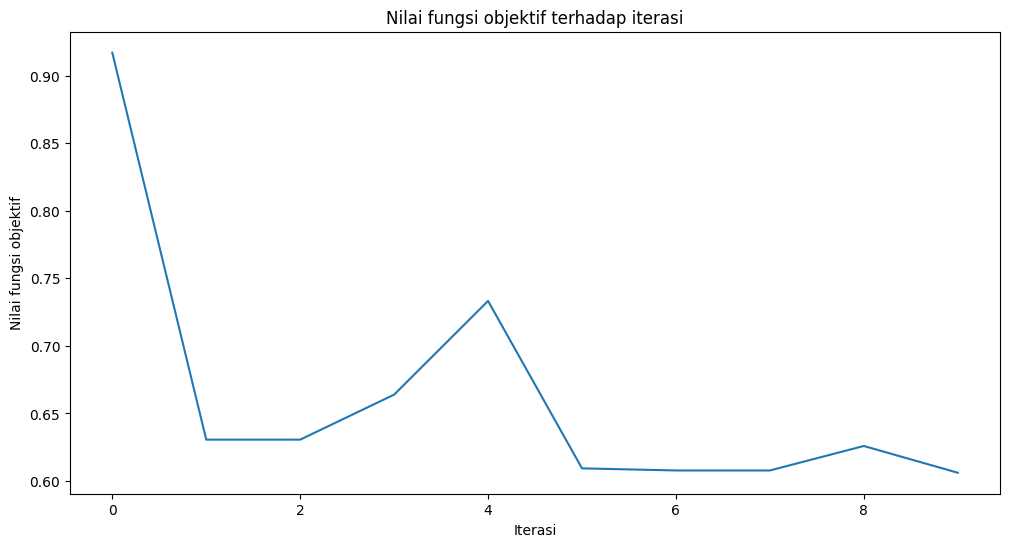

Waktu Training: 1 detik


In [108]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map_1,
    ansatz=ansatz_1,
    optimizer=optimizer,
    callback=callback_graph,
)

# hapus histori nilai obyektif
objective_func_vals = []

# membuat plot fungsi objektif terlihat lebih bagus.
plt.rcParams["figure.figsize"] = (12, 6)


start = time.time()
vqc.fit(train_x, train_y)
elapsed = time.time() - start

print(f"Waktu Training: {round(elapsed)} detik")

In [109]:
score_pelatihan_2 = vqc.score(train_x, train_y)
score_pengujian_2 = vqc.score(test_x, test_y)

print(f"VQC kuantum pada dataset pelatihan menggunakan RealAmplitudes: {score_pelatihan_2:.2f}")
print(f"VQC kuantum pada dataset uji menggunakan RealAmplitudes      : {score_pengujian_2:.2f}")

VQC kuantum pada dataset pelatihan menggunakan RealAmplitudes: 0.92
VQC kuantum pada dataset uji menggunakan RealAmplitudes      : 1.00


untuk melatih (train) sebuah model Klasifikasi Kuantum Variasi (VQC) pada dataset train_x dan train_y. Pelatihan ini menggunakan Ansatz EfficientSU2 untuk struktur sirkuitnya dan optimizer COBYLA untuk menyesuaikan parameter-parameter dalam Ansatz.

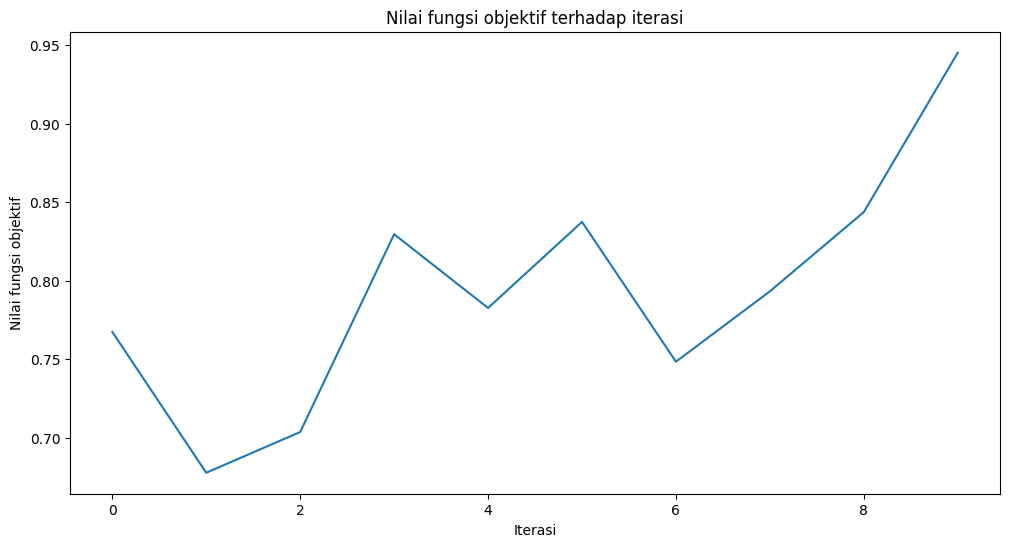

Waktu Training: 2 detik


In [110]:
from qiskit.circuit.library import EfficientSU2

ansatz_2 = EfficientSU2(num_qubits=jum_fitur, reps=3)
optimizer = COBYLA(maxiter=10)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map_1,
    ansatz=ansatz_2,               #  pakai anzats baru
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_x, train_y)
elapsed = time.time() - start

print(f"Waktu Training: {round(elapsed)} detik")

In [111]:
score_pelatihan_3 = vqc.score(train_x, train_y)
score_pengujian_3 = vqc.score(test_x, test_y)

print(f"VQC kuantum pada dataset pelatihan menggunakan EfficientSU2: {score_pelatihan_3:.2f}")
print(f"VQC kuantum pada dataset uji menggunakan EfficientSU2      : {score_pengujian_3:.2f}")

VQC kuantum pada dataset pelatihan menggunakan EfficientSU2: 0.88
VQC kuantum pada dataset uji menggunakan EfficientSU2      : 0.87


In [112]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = vqc.predict(test_x)
print(classification_report(test_y, y_pred, target_names=["Ganas (0)", "Jinak (1)"]))


              precision    recall  f1-score   support

   Ganas (0)       1.00      0.64      0.78        11
   Jinak (1)       0.83      1.00      0.90        19

    accuracy                           0.87        30
   macro avg       0.91      0.82      0.84        30
weighted avg       0.89      0.87      0.86        30



Menampilkan perbandingan performa antar model.

In [113]:
print(f"Model                     | Score Pelatihan | Score Pengujian")
print(f"VQC, 4 features, Anzats_1 | {score_pelatihan_1:10.2f} | {score_pengujian_1:10.2f}")
print(f"VQC, 2 features, Anzats_1 | {score_pelatihan_2:10.2f} | {score_pengujian_2:10.2f}")
print(f"VQC, 2 features, Anzats_2 | {score_pelatihan_3:10.2f} | {score_pengujian_3:10.2f}")

Model                     | Score Pelatihan | Score Pengujian
VQC, 4 features, Anzats_1 |       0.86 |       0.83
VQC, 2 features, Anzats_1 |       0.92 |       1.00
VQC, 2 features, Anzats_2 |       0.88 |       0.87


In [114]:
import qiskit
print(qiskit.__qiskit_version__)

{'qiskit-terra': '0.22.4', 'qiskit-aer': '0.11.2', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.39.5', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': '0.6.1'}


## Penjelasan

🔬 Tujuan dan Pendekatan
Menggunakan Quantum Machine Learning (QML) dengan algoritma Variational Quantum Classifier (VQC).

Dataset yang digunakan adalah Breast Cancer Wisconsin dari sklearn.datasets.

Dilakukan reduksi dimensi menggunakan PCA agar sesuai dengan kapasitas model kuantum yang terbatas (jumlah qubit maksimal ≈ 4).

⚙️ Tahapan Proses
1. Import dan Preprocessing:

Dataset terdiri dari 569 data dan 30 fitur.

Fitur dinormalisasi menggunakan MinMaxScaler.

PCA digunakan untuk mereduksi fitur menjadi 4 atau 2 dimensi.

Sampling 150 data acak dilakukan untuk efisiensi.

2. Quantum Circuit Construction:

Dibuat feature map dan ansatz (parameterized circuit) manual dan dari pustaka (seperti RealAmplitudes, EfficientSU2).

Tiga konfigurasi utama digunakan:

Ansatz_1 dengan 4 fitur

Ansatz_1 dengan 2 fitur

EfficientSU2 dengan 2 fitur

3. Model Training:

Optimizer: COBYLA (iterasi maksimal: 10).

Backend: Sampler() (simulator dari Qiskit).

Callback digunakan untuk memantau fungsi objektif selama pelatihan.

Training time: sekitar 1–2 detik per model.



| Model                        | Akurasi Training | Akurasi Testing |
| ---------------------------- | ---------------- | --------------- |
| VQC + 4 fitur + ansatz\_1    | 86%              | 83%             |
| VQC + 2 fitur + ansatz\_1    | 92%              | 100%             |
| VQC + 2 fitur + EfficientSU2 | 88%              | 87%             |


## 📌 Kesimpulan 

VQC adalah algoritma pembelajaran mesin berbasis komputer kuantum yang belajar membedakan kategori (klasifikasi) dengan menggunakan sirkuit kuantum yang bisa disesuaikan.


Quantum circuit paling optimal: VQC dengan PCA 2 fitur + Ansatz manual (Ansatz_1), mencapai akurasi 100%.

Quantum computing sangat menjanjikan untuk klasifikasi data jika jumlah fitur kecil dan model tidak kompleks.

Namun, keterbatasan infrastruktur kuantum (simulasi, waktu eksekusi, dan noise) masih menjadi kendala utama.

Cocok untuk eksperimen dan penelitian teknologi mutakhir, namun belum stabil untuk penggunaan industri saat ini.

